In [397]:
# Importing all packages needed for the project
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Oppgave 2

In [398]:
# Importing the data, and making it into a dataframe
# Code taken from: https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public
url = ('https://drive.google.com/file/d/1dlJTxcX1QU2riu2iuCc1G2175ESzjEXl/view?usp=share_link')
url = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(url, sep=';')

# Removing the unnecessary columns
df = df.drop(columns=['Trafikkregistreringspunkt', 'Vegreferanse', 'Fra', 'Til', '>= 24,0m', '16,0m - 24,0m',
                      '>= 16,0m', '12,5m - 16,0m', '7,6m - 12,5m','5,6m - 7,6m', 'Lengdekvalitetsgrad (%)', 'Ikke gyldig lengde',
                      'Antall timer ugyldig', 'Antall timer inkludert', 'Antall timer total','Trafikkmengde'])

# Setting the index to be the date
df = df.set_index('Dato')

# Separating the Navn column into two columns, one for the cycles and one for the cars
sykkel_df = df[df['Navn'].str.contains('sykkel|Sykkel')]

bil_df = df[~df['Navn'].str.contains('sykkel|Sykkel')]

# Filter the DataFrame to only include rows where 'Felt' is 'Totalt'
bil_df = bil_df[bil_df['Felt'] == 'Totalt']

# Filter the DataFrame to only include rows where 'Felt' is 'Totalt'
sykkel_df = sykkel_df[sykkel_df['Felt'] == 'Totalt']

bil_df.index = pd.to_datetime(bil_df.index, format='%Y-%m-%d')

bil_df = bil_df.pivot_table(index='Dato', columns='Navn', values='< 5,6m', aggfunc='sum')

bil_df = bil_df.reset_index()

# Convert non-numeric values to NaN
bil_df = bil_df.apply(pd.to_numeric, errors='coerce')

# Create a new column 'Total' by summing all the numeric columns for each row
bil_df['Total'] = bil_df.iloc[:, 2:].sum(axis=1)

# Select only the 'Dato' and 'Total' columns
df_summary = bil_df[['Dato', 'Total']].copy()

df_summary['Dato'] = pd.to_datetime(df_summary['Dato'])

In [399]:
# creating a dummy variable called bompenger that is a value between 0 and 1 after the date 2023-01-05
df_summary['bompenger'] = np.where(df_summary['Dato'] > '2023-01-05', 1, 0)

# Making dato into observations starting from 1 and going to the end of the dataframe
df_summary['Dummy_date'] = np.arange(1, len(df_summary) + 1)

# Doing the regression with total as the dependent variable and dato and bompenger as the independent variables
model = ols('Total ~ Dummy_date + bompenger', data=df_summary).fit()

print(model.summary())
print(model.params)

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     144.3
Date:                Mon, 22 May 2023   Prob (F-statistic):           4.79e-57
Time:                        00:54:49   Log-Likelihood:                -14938.
No. Observations:                1236   AIC:                         2.988e+04
Df Residuals:                    1233   BIC:                         2.990e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.461e+05   2589.992     56.423      0.0

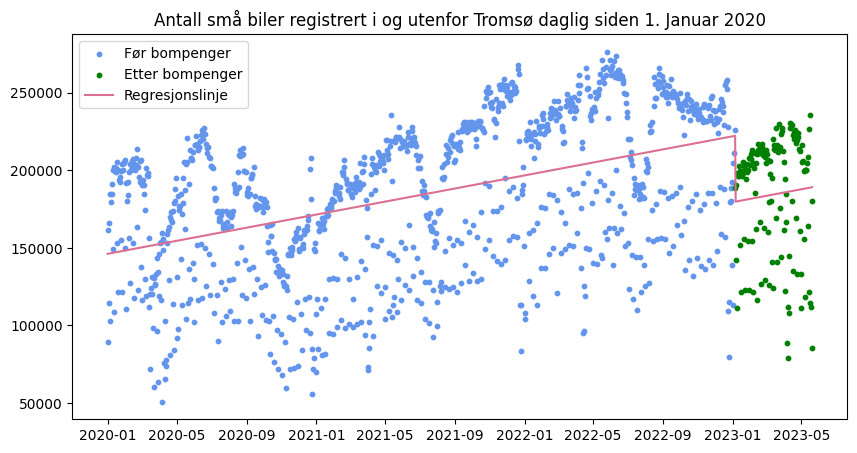

In [400]:
date_threshold = '2023-01-05'
data_before_threshold = df_summary[df_summary['Dato'] < date_threshold]
data_after_threshold = df_summary[df_summary['Dato'] >= date_threshold]

#plotting the data
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Antall små biler registrert i og utenfor Tromsø daglig siden 1. Januar 2020')

# Plot the data before the threshold date with one color
ax.scatter(data_before_threshold['Dato'], data_before_threshold['Total'], s=10, color='cornflowerblue', label='Før bompenger')

# Plot the data after the threshold date with another color
ax.scatter(data_after_threshold['Dato'], data_after_threshold['Total'], s=10, color='green', label='Etter bompenger')
# plotting the regression
ax.plot(df_summary['Dato'], model.params[0] + model.params[1] * df_summary['Dummy_date'] + model.params[2] * df_summary['bompenger'], color='palevioletred', label='Regresjonslinje')
ax.legend();

# Oppgave 3

## Noen sentrale forutsetninger

Vi forutsetter at konsumenten(bilistens) inntekt i sin helhet går med til konsum, hvor konsumenten har to valg å velge mellom, konsumere andre goder eller å kjøre elbil målt ved antall kilometer kjørt. Nytten pårvirkes bare av konsum av gode 1 og gode 2 idag og vi ser bort ifra muligheten for sparing.

## Konsumentens budsjettbetingelse

Konsumentens budsjettbetingelse er da gitt ved egen inntekt, videre antas det at prisen per enhet av gode 1 og 2 som vi kaller $p_1$ og $p_2$ er gitt sammen med konsumentens egen inntekt $m$. Videre vil jeg referere til konsumenten som bilisten.

$$m = p_1x_1 + p_2x_2 \tag{1}$$

Hvor $x_1$ er antall enheter av gode 1 og $x_2$ er antall enheter av gode 2.

Hvor prisen på andre goder som vi kaller for $p_2$ = 1 (dette er et direkte mål på penger) og prisen på pr kilometer kjørt for elbil som vi kaller for $p_1$ = 1,98 og $m$ = 1156. [Inntekt regnes ut ved å ta gjennomsnittlig årlig inntekt fra SSB i Tromsø og dele på 365](https://www.ssb.no/97014/median-inntekt-etter-skatt-etter-fylke-og-husholdningstype.kroner) Da blir budsjettbetingelsen 1156 = 1 $x_1$ + 1,98 $x_2$.

Vi kan løse denne ligningen med hensyn på en av variablene, eksempelvis $x_2$ og da kan vi omformulere ligningen slik:

$$x_2 = \frac{m}{p_2} - \frac{p_1}{p_2}x_1 \tag{7}$$

Dette er en rett linje som forteller at konsumenten kan kjøpe maksimalt $\frac{m}{p_2}$ enheter av gode 2, og for hver enhet av gode 1 som kjøpes må konsumenten gi opp $\frac{p_1}{p_2}$ enheter av gode 2. Da er $\frac{p_1}{p_2}$ den relative prisen på gode 1, og helningen til budsjettlinjen er $-\frac{p_1}{p_2}$.        

Følgende figur viser mulighetsområdet for konsum av andre goder og antall kilometer å kjøre for El-bilisten og for bensin/diesel bilisten.

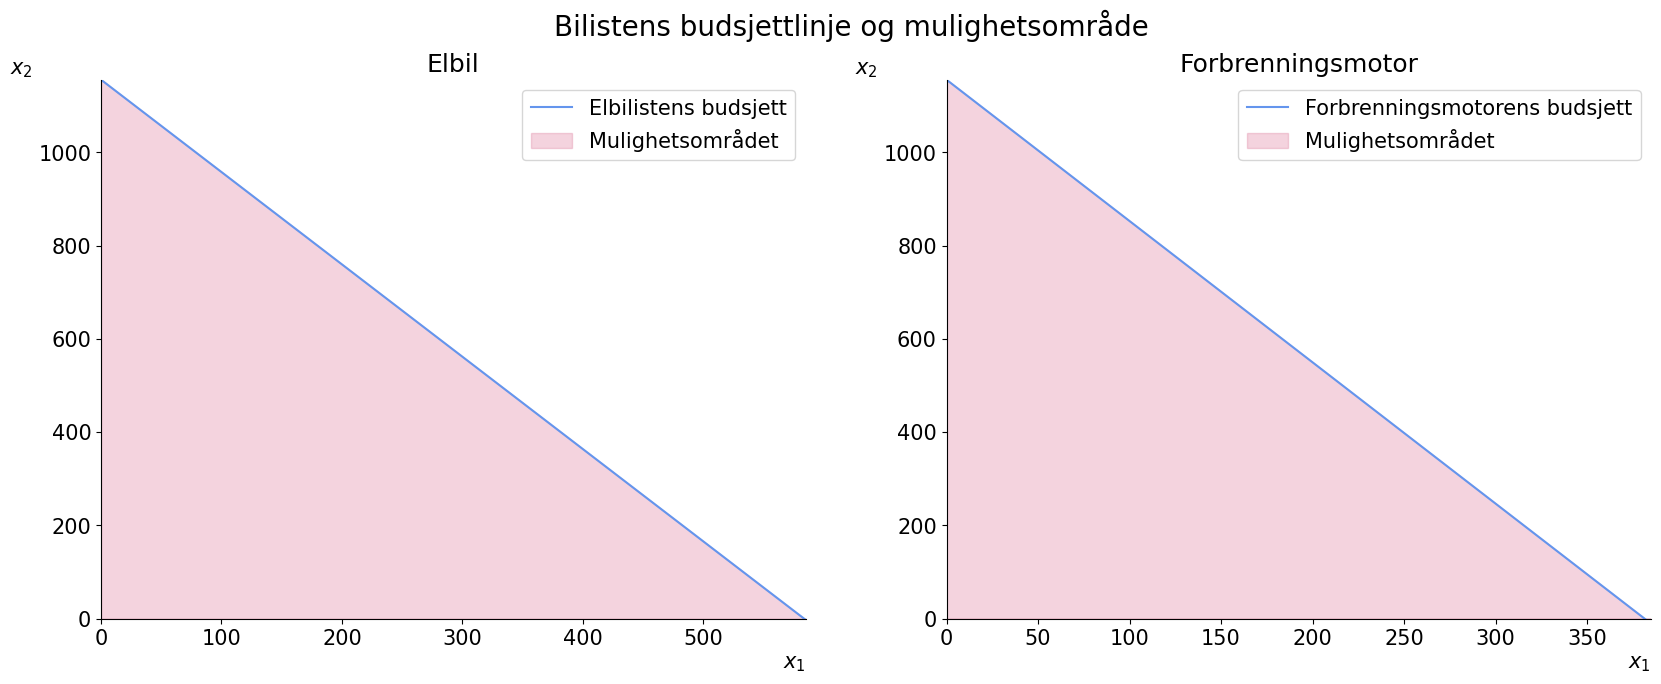

In [401]:
# Definerer hvor lang x-aksen skal være
x=np.linspace(0.001,585, 100)

# Definerer budsjettfunksjonen som beskrevet tidligere
def budsjett(M, p1, p2, x1):
    return M/p2 - p1*x1/p2

# Starter på første figur for kapittel 3
fig, ax = plt.subplots(1,2, sharey=True, figsize=(20,7))

# Setter inn verdier for M, p1 og p2 for elbilisten
ax[0].plot(x, budsjett(1156, 1.98, 1, x), color="cornflowerblue", label = 'Elbilistens budsjett')

# Setter x-aksen til å gå fra 0 til 585
ax[0].set(xlim=(0,585))

# Fyller inn mulighetsområdet
ax[0].fill_between(x, 0, budsjett(1156, 1.98, 1, x), color = "palevioletred",alpha = 0.3,label='Mulighetsområdet')

# Setter inn verdier for M, p1 og p2 for forbrenningsmotoren
ax[1].plot(x, budsjett(1156, 3.03, 1, x), color="cornflowerblue", label = 'Forbrenningsmotorens budsjett')

# Fyller inn mulighetsområdet
ax[1].fill_between(x, 0, budsjett(1156, 3.03, 1, x), color = "palevioletred",alpha = 0.3,label='Mulighetsområdet')

# Setter x-aksen til å gå fra 0 til 385
ax[1].set(xlim=(0,385))

# Løkke for å definere akser, y-limit og at det ikke skal være ramme, samt at det skal være ticks på høyre figur også
for j in range(2):
    ax[j].set_ylabel('$x_2$', loc='top', rotation=0, size=15)
    ax[j].set_xlabel('$x_1$', loc='right', size=15)
    ax[j].spines['top'].set_color('none')
    ax[j].spines['right'].set_color('none')
    ax[j].set_ylim(0, 1156)
    ax[j].tick_params(axis='both', which='major', labelsize=15,labelleft=True)
    
# Titler
fig.suptitle('Bilistens budsjettlinje og mulighetsområde', size=20)
ax[0].set_title('Elbil', size=18)
ax[1].set_title('Forbrenningsmotor', size=18)

# Legender
ax[0].legend(loc='best', fontsize=15)
ax[1].legend(loc='best', fontsize=15);


## Endringer i budsjettbetingelsen etter innføring av bompenger

Før innføringen av bompenger var prisen per kilometer for en elbilist 1,98 kroner og for en forbrenningsmotorbilist 3,03 kroner. Men vi skal også se på hva som skjer etter innføringen av bompenger. 


La oss se på noen forskjellige bompengescenarioer:

- Bilist type 1: Kjører 2 ganger daglig til jobb på tromsøya, 5 dager i uken, 48 uker i året. Med gyldig Autopassbrikke og utenom rushtid betaler bilisten 9,6 kr per passering.

5 * 48 = 240 som blir antall kjøredager i året. 240 kjøredager * 9,6 kroner i bompenger * 2 antall bompasseringer = 4608 kr ekstra i året til bompenger utenom rushtid.

- Bilist type 2: Kjører 2 ganger daglig til jobb på tromsøya, 5 dager i uken, 48 uker i året. Med gyldig Autopassbrikke i rushtid betaler bilisten 28,80 kr per passering.

5 * 48 = 240 som blir antall kjøredager i året. 240 kjøredager * 28,80 kroner i bompenger * 2 antall bompasseringer = 13824 kr ekstra i året til bompenger i rushtid.

- Bilist type 3: Kjører Elbil 2 ganger daglig til jobb på tromsøya, 5 dager i uken, 48 uker i året. Med gyldig Autopassbrikke og utenom rushtid betaler bilisten 4,80 kr per passering.

5 * 48 = 240 som blir antall kjøredager i året. 240 kjøredager * 4,80 kroner i bompenger * 2 antall bompasseringer = 2304 kr ekstra i året til bompenger utenom rushtid.

- Bilist type 4: Kjører Elbil 2 ganger daglig til jobb på tromsøya, 5 dager i uken, 48 uker i året. Med gyldig Autopassbrikke i rushtid betaler bilisten 28,80 kr per passering.

5 * 48 = 240 som blir antall kjøredager i året. 240 kjøredager * 14,40 kroner i bompenger * 2 antall bompasseringer = 6912 kr ekstra i året til bompenger i rushtid.


Videre ser vi på hvordan dette vil påvirke påslaget i pris per kilometer for to scenario, et for scenario 1 og et for scenario 3 med forbrenningsmotor og elbil.

La oss anta at både elbil og personbil kjører gjenomsnittlig 11 097 km i året i følge tall fra [SSB](https://www.ssb.no/statbank/table/12575/tableViewLayout1/).

Vi deler årlig pris på årlig antall gjennomsnittlig kjørelengde og får $4608/ 11097 = 0,415$ kr per km i påslag for scenario 1.

Vi deler årlig pris på årlig antall gjennomsnittlig kjørelengde og får $2304/ 11097 = 0,207$ kr per km i påslag for scenario 3.

Ifølge tall fra tabell 3 og 4 hentet fra [TØI](https://www.toi.no/getfile.php?mmfileid=74283) blir den totale ekstra prisen per kilometer kjørt for forbrenningsmotor $3,03 + 0,415 = 3,445$ kr per km kjørt og for elbil $1,98 + 0,207 = 2,187$ kr per km kjørt.

I figuren under kan man se hvordan budsjettlinjen til en elbilist og en forbrenningsmotorbilist reduseres etter innføringen av bompenger.

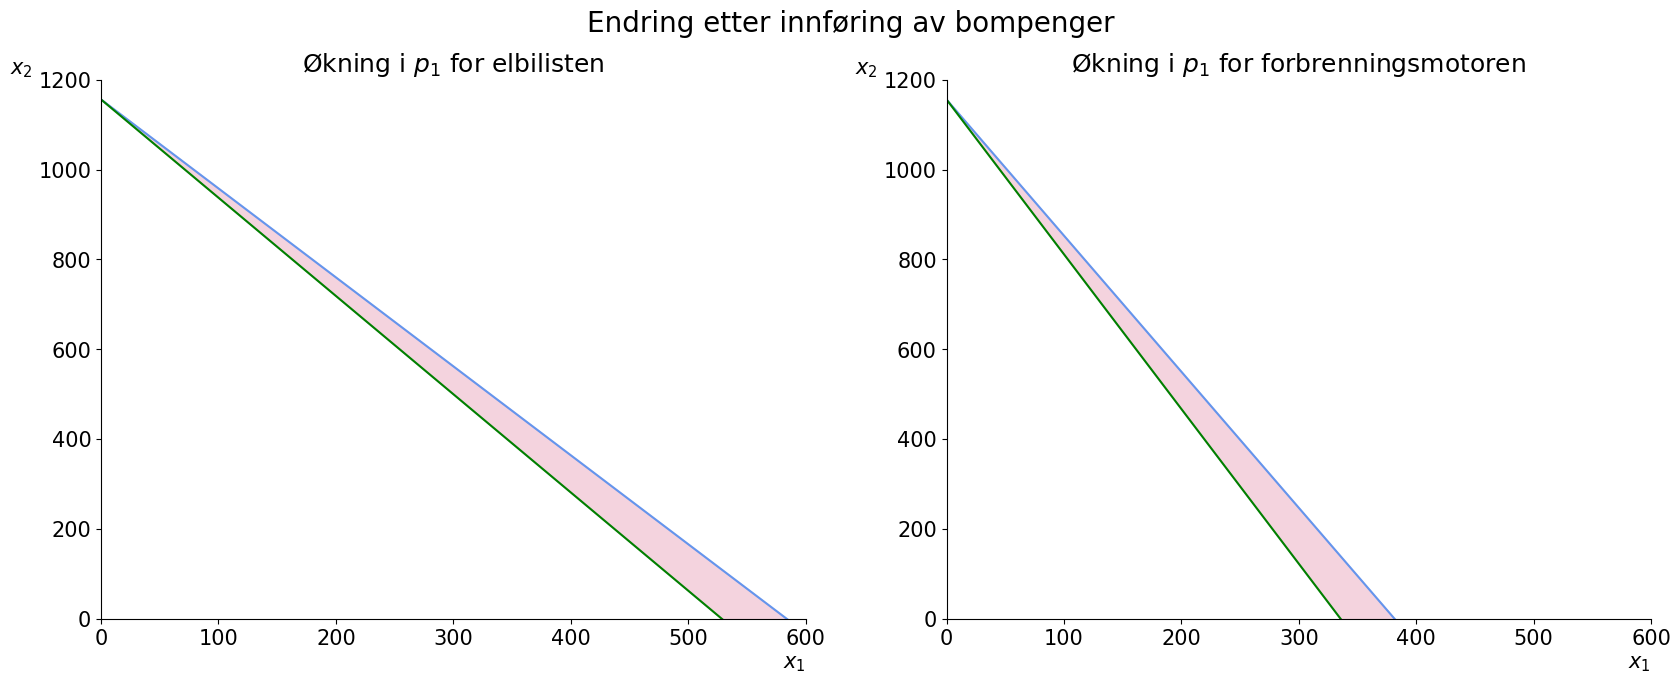

In [402]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(20,7))

# plott av oppr. linje

axs[0].plot(x, budsjett(1156, 1.98, 1, x), label = 'Opprinnelig budsjett', color="cornflowerblue")
axs[1].plot(x, budsjett(1156, 3.03, 1, x), label = 'Opprinnelig budsjett', color="cornflowerblue")

# linje med økt inntekt

axs[0].plot(x, budsjett(1156, 2.187, 1, x), label = 'Budsjett med økt $p_1$', color="green")

# økt pris

axs[1].plot(x, budsjett(1156, 3.445, 1, x), label = 'Budsjett med økt $p_1$', color="green")

# fyll mellom ny og gammel linje

axs[0].fill_between(x, budsjett(1156, 1.98, 1, x), budsjett(1156, 2.187, 1, x), color = "palevioletred",alpha = 0.3,label='Redusert mulighetsområde')
axs[1].fill_between(x, budsjett(1156, 3.03, 1, x), budsjett(1156, 3.445, 1, x), color = "palevioletred",alpha = 0.3,label='Redusert mulighetsområde')

# bruk løkke for å tegne aksene

for j in range(2):
    axs[j].set_ylabel('$x_2$', loc='top', rotation=0, size=15)
    axs[j].set_xlabel('$x_1$', loc='right', size=15)
    axs[j].set(xlim=(0,600))
    axs[j].set(ylim=(0,1200))
    axs[j].spines['top'].set_color('none')
    axs[j].spines['right'].set_color('none')
    axs[j].tick_params(axis='both', which='major', labelsize=15,labelleft=True)
    



# gi en passende tittel

fig.suptitle('Endring etter innføring av bompenger', size=20)
axs[0].set_title('Økning i $p_1$ for elbilisten', size=18)
axs[1].set_title('Økning i $p_1$ for forbrenningsmotoren', size=18)

# Legender
ax[0].legend(loc='best', fontsize=15)
ax[1].legend(loc='best', fontsize=15);

In [403]:
# etterspørselens priselastisitet -0.10 kort sikt -0.29 lang sikt

# symboler

x_1, x_2, a, b, U_0, p_1, p_2, m=sp.symbols("x_1 x_2 a b U_0 p_1 p_2 m", real=True, positive=True)


# nyttefunksjon
U=x_1**a*x_2**b

# vi må løse for x_2 og et gitt nyttenivå
x_2_ind_sol=sp.solve(U-U_0,x_2)[0]

indiff_x_2=sp.lambdify( (U_0,a,b,x_1), x_2_ind_sol)
indiff_x_2(U_0,a,b,x_1)

# budsjett
bud=p_1*x_1+p_2*x_2

# Beregne MSB

msb = sp.diff(U, x_1)/sp.diff(U,x_2)
display(msb)

a*x_2/(b*x_1)

In [404]:
# Løs likning (12)

x_2_rel=sp.solve(msb-p_1/p_2,x_2)[0]
display(x_2_rel)

b*p_1*x_1/(a*p_2)

In [405]:
budsj=bud.subs(x_2,x_2_rel)
display(budsj)
x_1_eq= sp.solve(budsj-m,x_1)[0]

# dette er likevektsløsning for x_1
#sett inn i x_2_rel for å få x_2_eq

x_2_eq= x_2_rel.subs(x_1,x_1_eq)
display(x_1_eq)
display(x_2_eq)

p_1*x_1 + b*p_1*x_1/a

a*m/(p_1*(a + b))

b*m/(p_2*(a + b))

In [406]:
# budsjettandeler

andel_x_1=p_1*x_1_eq/m
andel_x_2=p_2*x_2_eq/m
display(andel_x_1)
display(andel_x_2)

a/(a + b)

b/(a + b)

In [407]:
# a) vi må regne på de førsteordensderivertene til x_1_eq og x_2_eq

d_x_1_a = sp.simplify(sp.diff(x_1_eq,a))
d_x_1_b = sp.simplify(sp.diff(x_1_eq,b))
d_x_1_p_1 = sp.simplify(sp.diff(x_1_eq,p_1))
d_x_1_p_2 = sp.simplify(sp.diff(x_1_eq,p_2))
d_x_1_m = sp.simplify(sp.diff(x_1_eq,m))

d_x_2_a = sp.simplify(sp.diff(x_2_eq,a))
d_x_2_b = sp.simplify(sp.diff(x_2_eq,b))
d_x_2_p_1 = sp.simplify(sp.diff(x_2_eq,p_1))
d_x_2_p_2 = sp.simplify(sp.diff(x_2_eq,p_2))
d_x_2_m = sp.simplify(sp.diff(x_2_eq,m))

# Vi setter inn i en tabell

# bruk sp.latex for å få et fint uttrykk

from IPython.display import Markdown

tbl_ks=f"""
|   Endring i <div style="width:100px">                 | $x_1$ | $x_2$  |   
| :-------------------| :-------------------------:|:--------------------:|
| $a$     | ${sp.latex(d_x_1_a)}$           |${sp.latex(d_x_2_a)}$       |
| $b$     | ${sp.latex(d_x_1_b)}$              |   ${sp.latex(d_x_2_b)}$    |
| $p_1$ | ${sp.latex(d_x_1_p_1)}$ |        ${sp.latex(d_x_2_p_1)}$ |
| $p_2$ | ${sp.latex(d_x_1_p_2)}$ |       ${sp.latex(d_x_2_p_2)}$  |
| $m$    | ${sp.latex(d_x_1_m)}$   |         ${sp.latex(d_x_2_m)}$ | 
"""
display(Markdown(tbl_ks))


|   Endring i <div style="width:100px">                 | $x_1$ | $x_2$  |   
| :-------------------| :-------------------------:|:--------------------:|
| $a$     | $\frac{b m}{p_{1} \left(a + b\right)^{2}}$           |$- \frac{b m}{p_{2} \left(a + b\right)^{2}}$       |
| $b$     | $- \frac{a m}{p_{1} \left(a + b\right)^{2}}$              |   $\frac{a m}{p_{2} \left(a + b\right)^{2}}$    |
| $p_1$ | $- \frac{a m}{p_{1}^{2} \left(a + b\right)}$ |        $0$ |
| $p_2$ | $0$ |       $- \frac{b m}{p_{2}^{2} \left(a + b\right)}$  |
| $m$    | $\frac{a}{p_{1} \left(a + b\right)}$   |         $\frac{b}{p_{2} \left(a + b\right)}$ | 


In [408]:
# b) Elastisiteter

# gode 1

el_x_1_p_1 = sp.simplify(d_x_1_p_1*p_1/x_1_eq)
el_x_1_p_2 = sp.simplify(d_x_1_p_2*p_2/x_1_eq)
el_x_1_m = sp.simplify(d_x_1_m*m/x_1_eq)

# gode 2

el_x_2_p_1 = sp.simplify(d_x_2_p_1*p_1/x_2_eq)
el_x_2_p_2 = sp.simplify(d_x_2_p_2*p_2/x_2_eq)
el_x_2_m = sp.simplify(d_x_2_m*m/x_2_eq)


tbl_el=f"""
|   Elastisitet <div style="width:100px">                 | $x_1$ | $x_2$  |   
| :-------------------| :-------------------------:|:--------------------:|
| $p_1$ | ${sp.latex(el_x_1_p_1)}$ |        ${sp.latex(el_x_2_p_1)}$ |
| $p_2$ | ${sp.latex(el_x_1_p_2)}$ |       ${sp.latex(el_x_2_p_2)}$  |
| $m$    | ${sp.latex(el_x_1_m)}$   |         ${sp.latex(el_x_2_m)}$ | 
"""
display(Markdown(tbl_el))


|   Elastisitet <div style="width:100px">                 | $x_1$ | $x_2$  |   
| :-------------------| :-------------------------:|:--------------------:|
| $p_1$ | $-1$ |        $0$ |
| $p_2$ | $0$ |       $-1$  |
| $m$    | $1$   |         $1$ | 


In [409]:
# steg 1 har vi løst x_1_eq og x_2_eq

# steg 2
U_max=U.subs([(x_1,x_1_eq),(x_2,x_2_eq)])
display(U_max)

(a*m/(p_1*(a + b)))**a*(b*m/(p_2*(a + b)))**b

In [410]:
nytte = U_max.subs([(a,.25),(b,.4),(m,1156),(p_1,1.98),(p_2,1)])
x_1_num = x_1_eq.subs([(a,.25),(b,.4),(m,1156),(p_1,1.98),(p_2,1)])
x_2_num = x_2_eq.subs([(a,.25),(b,.4),(m,1156),(p_1,1.98),(p_2,1)])
display(nytte)
display(x_1_num)
display(x_2_num)

53.5391672004855

224.553224553225

711.384615384615

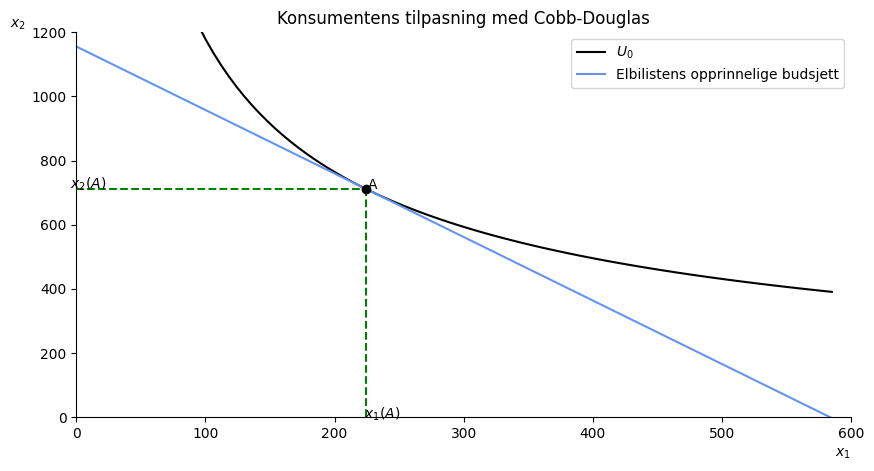

In [411]:
def create_ax():
                fig, ax = plt.subplots(figsize=(10,5))
                # ax.set_ylabel('$x_2$', loc='top', rotation=0)
                ax.set_xlabel('$x_1$', loc='right')
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                
                return fig, ax




# nå kan vi plotte
fig, ax=create_ax()

ax.set_ylabel('$x_2$', loc='top', rotation=0)
ax.plot(x, indiff_x_2(nytte,.25,.4,x), label='$U_{0}$', color='black')
ax.plot(x, budsjett(1156, 1.98, 1, x), color="cornflowerblue", label = 'Elbilistens opprinnelige budsjett')

# tegn inn tilpasningen
ax.vlines(x_1_num,0,x_2_num, color='green',ls='dashed')
ax.hlines(x_2_num,0,x_1_num, color='green',ls='dashed')

ax.set_xlim(0, 600)
ax.set_ylim(0, 1200)

ax.annotate('$x_1(A)$', (x_1_num-2, -5), annotation_clip=False)
ax.annotate('$x_2(A)$', (-5, x_2_num), annotation_clip=False)
ax.annotate('A', (x_1_num+1,x_2_num+1))
ax.plot(x_1_num, x_2_num , marker='o', color='black')
# tittel
ax.set_title('Konsumentens tilpasning med Cobb-Douglas')

#vis navnene:
ax.legend();

In [412]:
nytte2 = U_max.subs([(a,.25),(b,.4),(m,1156),(p_1,2.187),(p_2,1)])
x_1_num = x_1_eq.subs([(a,.25),(b,.4),(m,1156),(p_1,2.187),(p_2,1)])
x_2_num = x_2_eq.subs([(a,.25),(b,.4),(m,1156),(p_1,2.187),(p_2,1)])
display(nytte)
display(x_1_num)
display(x_2_num)

53.5391672004855

203.299215644895

711.384615384615

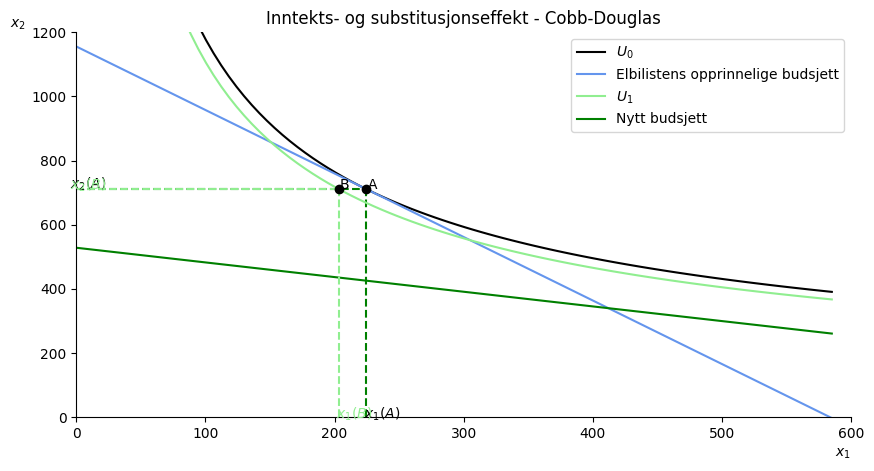

In [413]:
ax.plot(x, indiff_x_2(nytte2,.25,.4,x), label='$U_{1}$', color='lightgreen')
ax.plot(x, budsjett(1156, x, 2.187, 1), label = 'Nytt budsjett', color='green')

ax.vlines(x_1_num,0,x_2_num, color='lightgreen',ls='dashed')
ax.hlines(x_2_num,0,x_1_num, color='lightgreen',ls='dashed')

ax.annotate('$x_1(B)$', (x_1_num-2, -5), annotation_clip=False, color='lightgreen')
ax.annotate('$x_2(B)$', (-5, x_2_num-2), annotation_clip=False, color='lightgreen')
ax.annotate('B', (x_1_num+1,x_2_num+1))
ax.plot(x_1_num, x_2_num , marker='o', color='black')
# tittel
ax.set_title('Inntekts- og substitusjonseffekt - Cobb-Douglas')

#vis navnene:
ax.legend();

fig

In [414]:
# steg 3

# beregn fiktiv inntekt

# finn først hvordan oppnådd nytte er avhengig av inntekt gitt nye priser

V_m = U_max.subs([(a,.25),(b,.4),(p_1,2.187),(p_2,1)])
V_m

0.533277329036218*m**0.65

In [415]:
sp.solve(V_m-nytte, m)[0]

1201.06609727597

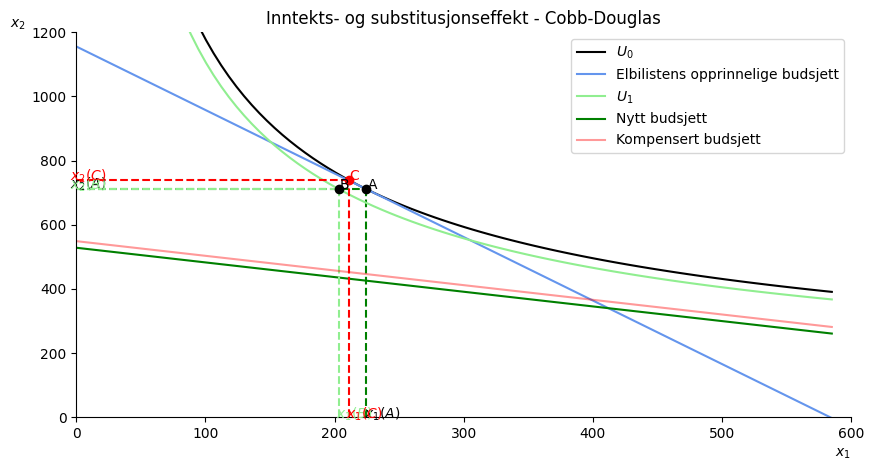

In [416]:
x_1_eq_komp = float(x_1_eq.subs([(a, .25), (b, .4), (m, 1201), (p_1, 2.187), (p_2, 1)]))
x_2_eq_komp = float(x_2_eq.subs([(a, .25), (b, .4), (m, 1201), (p_1, 2.187), (p_2, 1)]))

ax.plot(x, budsjett(1201, x, 2.187, 1), color='red', alpha=.4, label='Kompensert budsjett')

ax.vlines(x_1_eq_komp, 0, x_2_eq_komp, ls='dashed', color='red')
ax.hlines(x_2_eq_komp, 0, x_1_eq_komp, ls='dashed', color='red')

ax.annotate('$x_1(C)$', (x_1_eq_komp-2, -5), color='red', annotation_clip=False)
ax.annotate('$x_2(C)$', (-5, x_2_eq_komp-1), color= 'red', annotation_clip=False)
ax.annotate('C', (x_1_eq_komp+.5,x_2_eq_komp), color='red')
ax.plot(x_1_eq_komp, x_2_eq_komp , marker='o', color='red')
ax.legend();
fig